# Neural Network from Scratch with NumPy

## Introduction

This notebook demonstrates how to build a simple neural network from scratch using only NumPy, without relying on high-level deep learning libraries such as TensorFlow or Keras. The goal is to gain a deeper understanding of the core concepts behind neural networks by implementing each component manually.

We will apply our neural network to the MNIST dataset, a classic benchmark for handwritten digit recognition. By the end of this notebook, you will understand how neural networks learn from data and how to implement them from first principles.

---

## Plan of Action

1. **Import Libraries**  
   Load all necessary Python libraries (NumPy, Pandas, Matplotlib, etc.).

2. **Data Preparation**  
   Load the MNIST dataset, shuffle, and split into training, validation, and test sets.

3. **Network Initialization**  
   Define functions to initialize weights and biases for the neural network.

4. **Activation Functions**  
   Implement ReLU and softmax activation functions and their derivatives.

5. **Forward and Backward Propagation**  
   Build functions for forward pass, backward pass, and parameter updates.

6. **Utilities**  
   Add helper functions for predictions, accuracy, and loss calculation.

7. **Training Loop**  
   Implement the main training loop with loss and accuracy tracking.

8. **Hyperparameter Tuning**  
   Experiment with different hidden layer sizes and regularization strengths.

9. **Evaluation**  
   Evaluate the trained model on validation and test sets.

10. **Visualization**  
    Plot training metrics and visualize predictions.

11. **Model Saving/Loading**  
    Save and reload the trained model using pickle.

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle


In [3]:
# Load and prepare data
data = pd.read_csv('train.csv')
data = np.array(data)
np.random.shuffle(data)

In [4]:
m, n = data.shape
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n] / 255.

data_test = data[1000:2000].T
Y_test = data_test[0]
X_test = data_test[1:n] / 255.

data_train = data[2000:m].T
Y_train = data_train[0]
X_train = data_train[1:n] / 255.

In [5]:
# Initialization
def init_params(hidden_size=10):
    W1 = np.random.randn(hidden_size, 784) * np.sqrt(2 / 784)
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(10, hidden_size) * np.sqrt(2 / hidden_size)
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

In [6]:
# Activations
def ReLU(Z): return np.maximum(Z, 0)
def ReLU_deriv(Z): return Z > 0
def softmax(Z):
    Z -= np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

In [7]:
# Forward/Backward
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, one_hot_Y, lambd):
    m = X.shape[1]
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T) + (lambd / m) * W1
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

In [8]:
# Utilities
def get_predictions(A2): return np.argmax(A2, 0)
def get_accuracy(predictions, Y): return np.sum(predictions == Y) / Y.size
def compute_loss(A2, Y):
    m = Y.shape[0]
    log_likelihood = -np.log(A2[Y, range(m)])
    return np.sum(log_likelihood) / m

In [9]:
# Training Loop with loss tracking
def gradient_descent(X, Y, alpha, iterations, lambd=0, hidden_size=10):
    W1, b1, W2, b2 = init_params(hidden_size)
    one_hot_Y = one_hot(Y)
    acc_list, loss_list = [], []

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        loss = compute_loss(A2, Y)
        acc = get_accuracy(get_predictions(A2), Y)
        acc_list.append(acc)
        loss_list.append(loss)

        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, one_hot_Y, lambd)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        if i % 100 == 0:
            print(f"Iter {i}: Acc={acc:.4f}, Loss={loss:.4f}")
    return W1, b1, W2, b2, acc_list, loss_list

In [10]:
# Evaluation
def evaluate_model(W1, b1, W2, b2, X_val, Y_val):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X_val)
    preds = get_predictions(A2)
    acc = get_accuracy(preds, Y_val)
    print("Sample Predictions:", preds[:10])
    print("True Labels        :", Y_val[:10])
    return acc

In [11]:
# Plotting
def plot_metrics(acc_list, loss_list):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc_list)
    plt.title("Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(loss_list)
    plt.title("Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()

In [12]:
# Hyperparameter tuning
def find_best_hidden_size(X, Y, X_val, Y_val, alpha, iterations, lambd, hidden_sizes):
    best_size, best_acc = None, 0
    for size in hidden_sizes:
        print(f"\nTuning hidden size: {size}")
        W1, b1, W2, b2, _, _ = gradient_descent(X, Y, alpha, iterations, lambd, size)
        acc = evaluate_model(W1, b1, W2, b2, X_val, Y_val)
        if acc > best_acc:
            best_acc, best_size = acc, size
    print(f"\n✅ Best Hidden Size: {best_size} with Accuracy: {best_acc:.4f}")
    return best_size

def find_best_lambda(X, Y, X_val, Y_val, alpha, iterations, lambdas, hidden_size):
    best_lambd, best_acc = None, 0
    for lambd in lambdas:
        print(f"\nTuning lambda: {lambd}")
        W1, b1, W2, b2, _, _ = gradient_descent(X, Y, alpha, iterations, lambd, hidden_size)
        acc = evaluate_model(W1, b1, W2, b2, X_val, Y_val)
        if acc > best_acc:
            best_acc, best_lambd = acc, lambd
    print(f"\n✅ Best Lambda: {best_lambd} with Accuracy: {best_acc:.4f}")
    return best_lambd

In [13]:
# Visual prediction
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return get_predictions(A2)

def test_prediction(index, W1, b1, W2, b2):
    image = X_train[:, index].reshape(-1, 1)
    pred = make_predictions(image, W1, b1, W2, b2)
    label = Y_train[index]
    print(f"Prediction: {pred}, Label: {label}")
    plt.imshow(image.reshape(28, 28) * 255, cmap='gray')
    plt.show()

In [14]:
# Main execution
best_size = find_best_hidden_size(X_train, Y_train, X_dev, Y_dev, alpha=0.1, iterations=300, lambd=0, hidden_sizes=[64, 110, 128])
best_lambd = find_best_lambda(X_train, Y_train, X_dev, Y_dev, alpha=0.1, iterations=300, lambdas=[0, 0.01, 0.1], hidden_size=best_size)

W1, b1, W2, b2, acc_list, loss_list = gradient_descent(X_train, Y_train, alpha=0.1, iterations=500, lambd=best_lambd, hidden_size=best_size)



Tuning hidden size: 64
Iter 0: Acc=0.1084, Loss=2.4335
Iter 100: Acc=0.8783, Loss=0.4656
Iter 200: Acc=0.8980, Loss=0.3655
Sample Predictions: [2 4 3 6 3 0 5 9 8 5]
True Labels        : [2 4 3 6 3 0 5 9 1 5]

Tuning hidden size: 110
Iter 0: Acc=0.1056, Loss=2.3427
Iter 100: Acc=0.8835, Loss=0.4447
Iter 200: Acc=0.9034, Loss=0.3490
Sample Predictions: [2 4 3 6 3 0 5 9 8 5]
True Labels        : [2 4 3 6 3 0 5 9 1 5]

Tuning hidden size: 128
Iter 0: Acc=0.1040, Loss=2.3617
Iter 100: Acc=0.8828, Loss=0.4531
Iter 200: Acc=0.9028, Loss=0.3534
Sample Predictions: [2 4 3 6 3 0 5 9 8 5]
True Labels        : [2 4 3 6 3 0 5 9 1 5]

✅ Best Hidden Size: 110 with Accuracy: 0.9160

Tuning lambda: 0
Iter 0: Acc=0.0593, Loss=2.4123
Iter 100: Acc=0.8829, Loss=0.4520
Iter 200: Acc=0.9029, Loss=0.3535
Sample Predictions: [2 4 3 6 3 0 5 9 5 5]
True Labels        : [2 4 3 6 3 0 5 9 1 5]

Tuning lambda: 0.01
Iter 0: Acc=0.1224, Loss=2.3478
Iter 100: Acc=0.8817, Loss=0.4512
Iter 200: Acc=0.9025, Loss=0.3537


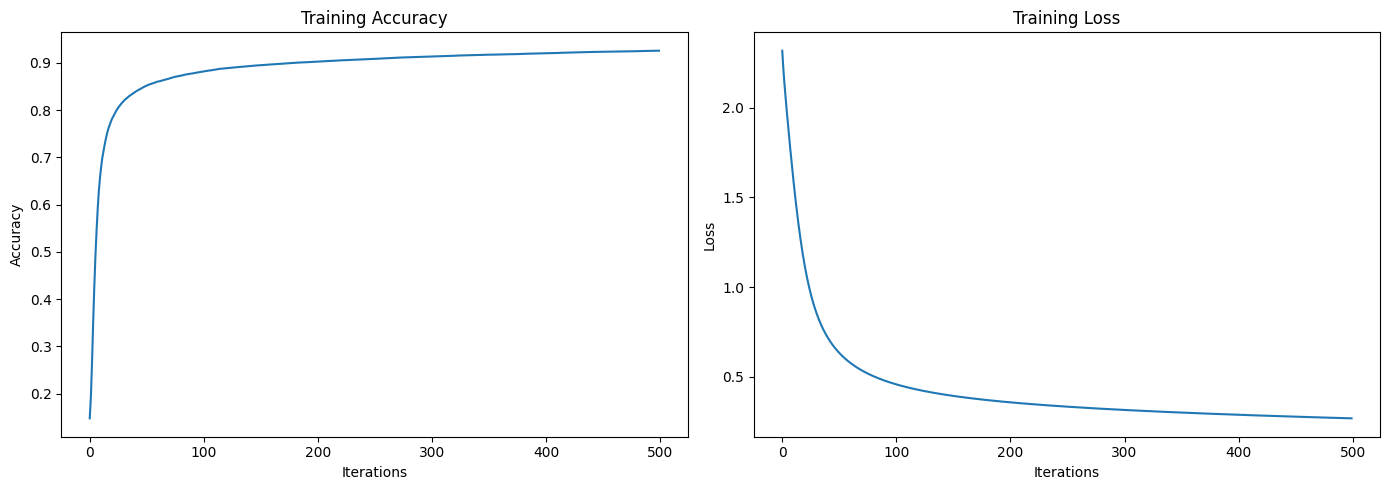

<Figure size 640x480 with 0 Axes>

In [16]:
# Plot final training metrics
plot_metrics(acc_list, loss_list)
plt.savefig('training_metrics.png')


In [17]:
# Evaluate
print("\n📊 Final Evaluation:")
print("Dev Accuracy :", evaluate_model(W1, b1, W2, b2, X_dev, Y_dev))
print("Test Accuracy:", evaluate_model(W1, b1, W2, b2, X_test, Y_test))



📊 Final Evaluation:
Sample Predictions: [2 4 3 6 3 0 5 9 5 5]
True Labels        : [2 4 3 6 3 0 5 9 1 5]
Dev Accuracy : 0.927
Sample Predictions: [6 2 1 0 0 6 4 7 6 9]
True Labels        : [6 2 1 0 0 6 4 7 6 9]
Test Accuracy: 0.911


Prediction: [7], Label: 7


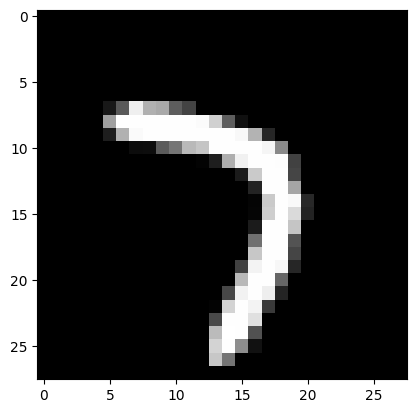

Prediction: [0], Label: 0


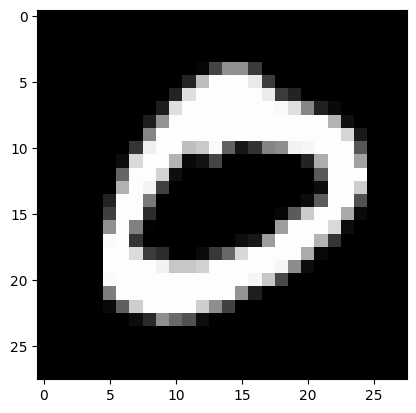

Prediction: [6], Label: 6


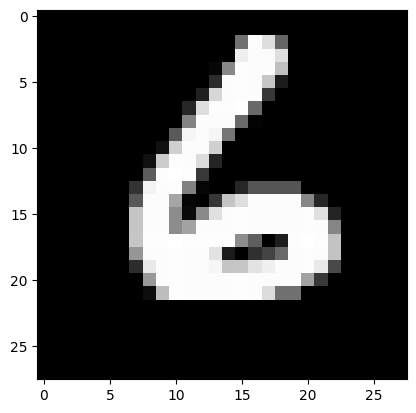

Prediction: [4], Label: 4


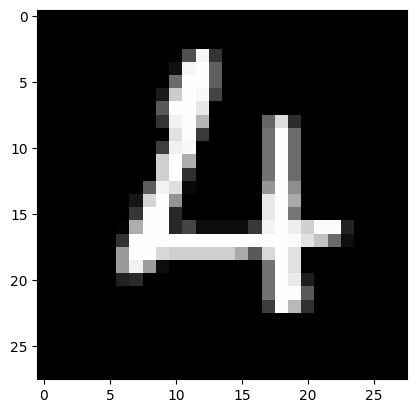

Prediction: [4], Label: 4


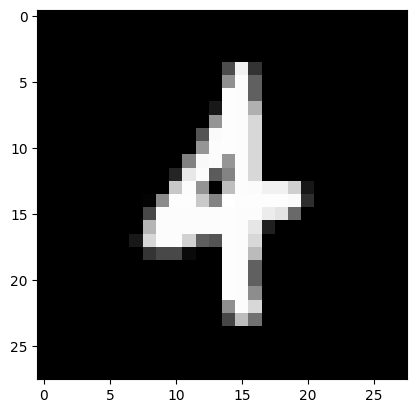

In [18]:
# Visual predictions
for i in range(5, 50, 10):
    test_prediction(i, W1, b1, W2, b2)

In [20]:
import pickle

# Save
with open('mnist_model.pkl', 'wb') as f:
    pickle.dump((W1, b1, W2, b2), f)

# Load
with open('mnist_model.pkl', 'rb') as f:
    W1, b1, W2, b2 = pickle.load(f)
